# Dask Delayed - Parallelism

- Delays the execution of tasks.
- Builds a task graph
- Dask scheduler exploits the parallelism from the task graph
- Useful for cases that don't fit with the collections

In [1]:
# Importing dask dataframe
import dask
import dask.delayed as delayed
import time
%load_ext memory_profiler
dask.__version__

'2.30.0'

### Simple Example  

Let us consider the following mathematical steps

Increase the value by one
\begin{align}
 x & = x + 1
\end{align}
Decrease the value by two
\begin{align}
 y & = y - 2
\end{align}
Add two values
\begin{align}
 z & = x + y
\end{align}

#### Task Order
- x and y can be evaluated independently
- z value depends on the evaluation of x and y

In [2]:
# Define simple functions for increament, decrement, and add operations
sleep_time = 1
def inc(x):
    time.sleep(sleep_time)
    return x + 1

def dec(x):
    time.sleep(sleep_time)
    return x - 1

def add(x, y):
    time.sleep(sleep_time)
    return x + y

Serial task executions. Each function takes a second, so executing three functions in sequeence will take three seconds. 

In [3]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
print("computed result ", z)

computed result  3
CPU times: user 1.07 ms, sys: 379 µs, total: 1.45 ms
Wall time: 3.01 s


Now lets build the task-graph with dask.delayed function. 

In [4]:
delayed_inc = delayed(inc)
delayed_dec = delayed(dec)
delayed_add = delayed(add)

In [5]:
x = delayed_inc(1)
y = delayed_dec(2)
z = delayed_add(x, y)
z

Delayed('add-99dfd1f0-79e4-4c21-a808-2f12e2f669c2')

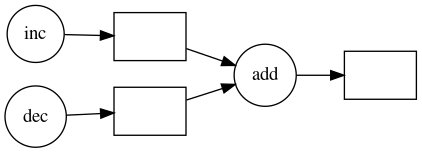

In [6]:
z.visualize(rankdir='LR')

The task-graph shows three tasks. Two of them are independent and they can be executed concurrently. So the total execution time will be two seconds. 

In [7]:
%%time
print("computed result ", z.compute())

computed result  3
CPU times: user 10 ms, sys: 12.1 ms, total: 22.1 ms
Wall time: 2.04 s


## Parallelizing a for loop

In [8]:
data = list(range(0,20))

In [9]:
%%time
results = []
for i in data:
    x = inc(i)
    y = dec(i)
    z = add(x, y)
    results.append(z) 
total = sum(results)
print("computed result ", total)

computed result  380
CPU times: user 2.85 ms, sys: 2.99 ms, total: 5.84 ms
Wall time: 1min


In [10]:
%%time
results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)  
total = delayed(sum)(results)
print("computed result ", total.compute())

computed result  380
CPU times: user 19.9 ms, sys: 9.72 ms, total: 29.7 ms
Wall time: 3.03 s


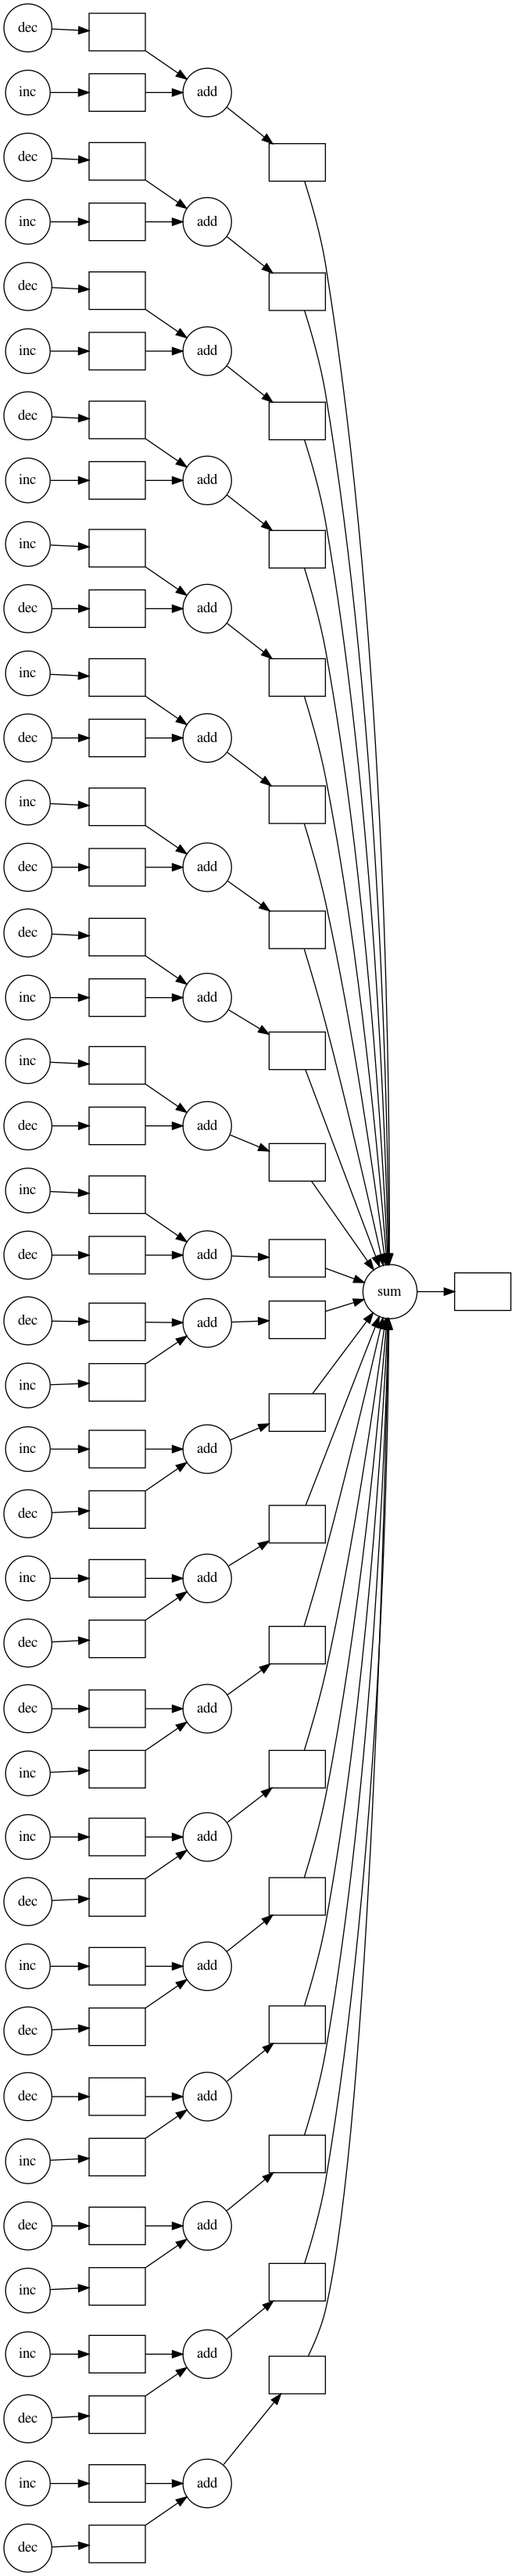

In [12]:
total.visualize(rankdir='LR')

### Dask Scheduler - Threads (Default)

In [13]:
%%time
results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute(scheduler='threads'))

computed result  380
CPU times: user 17.1 ms, sys: 10.9 ms, total: 28.1 ms
Wall time: 3.02 s


### Dask Scheduler - Processes

In [14]:
%%time
results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute(scheduler='processes'))

computed result  380
CPU times: user 109 ms, sys: 171 ms, total: 279 ms
Wall time: 3.54 s


### Dask Scheduler - single-threaded (for debugging)

In [15]:
%%time

results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute(scheduler='single-threaded'))

computed result  380
CPU times: user 15.1 ms, sys: 3.33 ms, total: 18.4 ms
Wall time: 1min


### Dask Distributed Scheduler (For scaling)

In [17]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
client 

Client Scheduler: tcp://127.0.0.1:38573 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.00 GB


In [18]:
%%time

results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute())

computed result  380
CPU times: user 740 ms, sys: 105 ms, total: 845 ms
Wall time: 15.3 s


In [19]:
client.shutdown()

In [20]:
from dask.distributed import Client, LocalCluster
client = Client(n_workers=8, threads_per_worker=2, memory_limit='4GB')
client 

Client Scheduler: tcp://127.0.0.1:45651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 32.00 GB


In [21]:
%%time

results = []
for i in data:
    d_x = delayed(inc)(i)
    d_y = delayed(dec)(i)
    d_z = delayed(add)(d_x, d_y)
    results.append(d_z)
    
total = delayed(sum)(results)
print("computed result ", total.compute())

computed result  380
CPU times: user 516 ms, sys: 78.5 ms, total: 594 ms
Wall time: 4.08 s


In [ ]:
client.shutdown()